In [85]:
import re

def clean_latex_string(s):
    # Remove leading and trailing $
    s = s.strip('$')
    # Remove all backslashes
    s = s.replace('\\', '')
    # Replace 'pm' (from '\pm' or any residue) with ±
    s = re.sub(r'\s*pm\s*', ' +- ', s)
    return s

def latex_to_results(latex_str):
    tabular_match = re.search(r'\\begin{tabular}{.*?}(.*?)\\end{tabular}', latex_str, re.DOTALL)
    if not tabular_match:
        raise ValueError("No tabular block found.")
    tabular_str = tabular_match.group(1)

    results = []
    for line in tabular_str.splitlines():
        line = line.strip()
        if (
            not line
            or line.startswith("\\")
            or '&' not in line
            or 'Pair' in line
            or 'Score' in line
        ):
            continue

        # Remove trailing \\
        if line.endswith('\\\\'):
            line = line[:-2].strip()
        elif line.endswith('\\'):
            line = line[:-1].strip()

        cols = [c.strip() for c in line.split('&')]
        if len(cols) != 7:
            continue  # Skip malformed lines

        # Parse columns
        pair = clean_latex_string(cols[0])
        cointegration_score_str = cols[1]

        sci_match = re.match(
            r'^\$?([-\d\.]+)\\times\s*10\^\{(-?\d+)\}\$?$', cointegration_score_str)
        if sci_match:
            cointegration_score = float(sci_match.group(1)) * (10 ** int(sci_match.group(2)))
        else:
            try:
                cointegration_score = float(cointegration_score_str.replace('$', '').replace('%', '').strip())
            except:
                cointegration_score = cointegration_score_str

        val_mse = float(cols[2])
        test_mse = float(cols[3])
        yoy_str = clean_latex_string(cols[4])
        gt_yoy = clean_latex_string(cols[5])
        returns_score = float(cols[6])

        results.append((pair, cointegration_score, val_mse, test_mse, yoy_str, gt_yoy, returns_score))
    return results

In [86]:
import numpy as np

kalman_results_strings = [

r"""\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (SHV,SMH) & $2.46\times 10^{-4}$ & 3.62432 & 6.24861 & $4.96\% \pm 0.35\%$ & TLOE* & nan \\
2. (SHV,ONEQ) & $4.04\times 10^{-4}$ & 14.37914 & 7.31014 & $3.23\% \pm 0.22\%$ & 33.16\% & 0.78 \\
3. (SHV,PHO) & $4.13\times 10^{-4}$ & 12.98751 & 8.91065 & $1.14\% \pm 0.06\%$ & 14.67\% & 0.88 \\
4. (SHV,PDP) & $9.15\times 10^{-4}$ & 12.11053 & 7.17672 & $3.39\% \pm 0.39\%$ & 43.99\% & 0.72 \\
5. (DVY,PEY) & $1.41\times 10^{-3}$ & 14.02045 & 22.46558 & $0.03\% \pm 0.02\%$ & 0.10\% & 1.00 \\
6. (PFF,EMB) & $1.45\times 10^{-3}$ & 4.11138 & 10.39903 & $1.36\% \pm 0.24\%$ & 0.71\% & 1.01 \\
7. (IGSB,BND) & $1.56\times 10^{-3}$ & 0.47129 & 3.46026 & $0.10\% \pm 0.16\%$ & -0.36\% & 1.00 \\
8. (IFGL,SHV) & $3.95\times 10^{-3}$ & 0.84092 & 4.17398 & $-59.52\% \pm 49.03\%$ & 0.41\% & 0.40 \\
9. (PRFZ,SCZ) & $4.47\times 10^{-3}$ & 62.79876 & 15.44644 & $0.76\% \pm 0.24\%$ & 0.31\% & 1.00 \\
10. (IFGL,EMB) & $4.61\times 10^{-3}$ & 0.47540 & 0.80221 & $1.58\% \pm 0.25\%$ & 0.53\% & 1.01 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $7.71\times 10^{-4}$ & 3.27634 & 1.23317 & $0.68\% \pm 0.07\%$ & 0.35\% & 1.00 \\
2. (IFGL,EMB) & $1.98\times 10^{-3}$ & 3.25643 & 6.62449 & $0.74\% \pm 0.16\%$ & -0.03\% & 1.01 \\
3. (IFGL,SHV) & $2.30\times 10^{-3}$ & 1.73315 & 4.47843 & $1.17\% \pm 0.16\%$ & 0.32\% & 1.01 \\
4. (IGSB,BND) & $2.75\times 10^{-3}$ & 0.99128 & 31.00205 & $0.32\% \pm 0.09\%$ & 0.19\% & 1.00 \\
5. (IFGL,SOXX) & $2.88\times 10^{-3}$ & 0.81478 & 23.39865 & $3.17\% \pm 0.64\%$ & 23.38\% & 0.84 \\
6. (IFGL,SMH) & $2.91\times 10^{-3}$ & 0.74851 & 24.67326 & $3.31\% \pm 0.77\%$ & 19.67\% & 0.86 \\
7. (IFGL,PHO) & $2.93\times 10^{-3}$ & 6.36724 & 34.76899 & $1.62\% \pm 0.05\%$ & 12.06\% & 0.91 \\
8. (IFGL,PDP) & $2.97\times 10^{-3}$ & 4.51497 & 72.84399 & $0.78\% \pm 0.06\%$ & TLOE* & nan \\
9. (IFGL,FTCS) & $2.99\times 10^{-3}$ & 12.57848 & 44.07794 & $1.71\% \pm 0.19\%$ & 12.47\% & 0.90 \\
10. (IFGL,USIG) & $3.01\times 10^{-3}$ & 2.38542 & 20.71949 & $0.49\% \pm 0.08\%$ & -0.11\% & 1.01 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $5.58\times 10^{-4}$ & 0.50624 & 20.34508 & $4.49\% \pm 0.77\%$ & 0.61\% & 1.04 \\
2. (IFGL,EMB) & $1.40\times 10^{-3}$ & 0.87225 & 16.96470 & $0.87\% \pm 0.04\%$ & 0.43\% & 1.00 \\
3. (IGSB,BND) & $1.89\times 10^{-3}$ & 0.87763 & 31.51380 & $5.10\% \pm 0.26\%$ & 0.88\% & 1.04 \\
4. (USIG,IEI) & $2.78\times 10^{-3}$ & 14.20624 & 2.49067 & $0.73\% \pm 0.14\%$ & 1.30\% & 0.99 \\
5. (IGF,DVY) & $2.82\times 10^{-3}$ & 12.19978 & 129.67840 & $0.48\% \pm 0.11\%$ & TLOE* & nan \\
6. (DVY,PEY) & $3.45\times 10^{-3}$ & 1.19037 & 3.14572 & $0.18\% \pm 0.03\%$ & 0.27\% & 1.00 \\
7. (IGIB,IEI) & $4.50\times 10^{-3}$ & 36.07088 & 4.97859 & $1.25\% \pm 0.27\%$ & 1.15\% & 1.00 \\
8. (IFGL,SOXX) & $4.65\times 10^{-3}$ & 8.74614 & 30.83984 & $0.45\% \pm 0.06\%$ & TLOE* & nan \\
9. (IFGL,SMH) & $4.65\times 10^{-3}$ & 9.17749 & 35.56703 & $0.43\% \pm 0.06\%$ & TLOE* & nan \\
10. (IFGL,PHO) & $5.30\times 10^{-3}$ & 20.33401 & 51.68065 & $0.46\% \pm 0.10\%$ & 3.70\% & 0.97 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $2.82\times 10^{-4}$ & 0.44357 & 2.44415 & $0.26\% \pm 0.04\%$ & -0.06\% & 1.00 \\
2. (IFGL,EMB) & $7.70\times 10^{-4}$ & 2.67912 & 7.37119 & $0.33\% \pm 0.07\%$ & 0.65\% & 1.00 \\
3. (IGF,DVY) & $1.17\times 10^{-3}$ & 77.92793 & 38.25796 & $0.95\% \pm 0.04\%$ & TLOE* & nan \\
4. (IGIB,IEI) & $1.25\times 10^{-3}$ & 1.38396 & 56.77418 & $1.34\% \pm 0.22\%$ & 0.50\% & 1.01 \\
5. (DVY,PEY) & $1.57\times 10^{-3}$ & 1.05452 & 2.53301 & $0.01\% \pm 0.01\%$ & 0.15\% & 1.00 \\
6. (USIG,IEI) & $1.67\times 10^{-3}$ & 1.23820 & 36.09742 & $1.06\% \pm 0.14\%$ & 0.61\% & 1.00 \\
7. (IFGL,BND) & $1.93\times 10^{-3}$ & 2.87954 & 37.54439 & $0.22\% \pm 0.02\%$ & 0.25\% & 1.00 \\
8. (IFGL,SMH) & $2.58\times 10^{-3}$ & 14.52957 & 9.56665 & $4.55\% \pm 0.44\%$ & 16.05\% & 0.90 \\
9. (IFGL,MBB) & $2.63\times 10^{-3}$ & 2.49472 & 45.48907 & $0.28\% \pm 0.04\%$ & -0.27\% & 1.01 \\
10. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 13.69404 & 13.00471 & $3.08\% \pm 0.21\%$ & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 1.62590 & 47.79868 & $0.77\% \pm 0.13\%$ & 0.10\% & 1.01 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 38.03334 & 55.19024 & $1.20\% \pm 0.14\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 16.15572 & 2.23287 & $1.09\% \pm 0.12\%$ & 0.39\% & 1.01 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 12.00864 & 52.11113 & $1.13\% \pm 0.15\%$ & 0.05\% & 1.01 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 11.49597 & 55.44654 & $1.55\% \pm 0.21\%$ & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 14.12800 & 141.67952 & $0.74\% \pm 0.16\%$ & -0.25\% & 1.01 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 30.15172 & 56.49230 & $0.79\% \pm 0.07\%$ & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 1.65947 & 16.84568 & $11.50\% \pm 0.67\%$ & 26.74\% & 0.88 \\
9. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 4.06293 & 35.82744 & $6.31\% \pm 0.64\%$ & 11.34\% & 0.95 \\
10. (IGF,PPH) & $2.29\times 10^{-3}$ & 6.47678 & 10.88732 & $0.78\% \pm 0.07\%$ & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
"""]

transformer_results_strings = [
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (SHV,SMH) & $2.46\times 10^{-4}$ & 0.33193 & 2.22423 & TLOE* & TLOE* & nan \\
2. (SHV,ONEQ) & $4.04\times 10^{-4}$ & 0.09506 & 1.27594 & TLOE* & 33.16\% & -1 \\
3. (SHV,PHO) & $4.13\times 10^{-4}$ & 1.50177 & 1.61198 & $-10.92\% \pm 46.61\%$ & 14.67\% & 0.78 \\
4. (SHV,PDP) & $9.15\times 10^{-4}$ & 0.06638 & 0.63493 & TLOE* & 43.99\% & -1 \\
5. (DVY,PEY) & $1.41\times 10^{-3}$ & 0.09973 & 0.16805 & $0.07\% \pm 0.01\%$ & 0.10\% & 1.00 \\
6. (PFF,EMB) & $1.45\times 10^{-3}$ & 0.11254 & 0.32286 & $0.32\% \pm 0.01\%$ & 0.71\% & 1.00 \\
7. (IGSB,BND) & $1.56\times 10^{-3}$ & 0.02444 & 0.98751 & $0.44\% \pm 0.02\%$ & -0.36\% & 1.01 \\
8. (IFGL,SHV) & $3.95\times 10^{-3}$ & 0.25714 & 0.13834 & $-0.17\% \pm 0.04\%$ & 0.41\% & 0.99 \\
9. (PRFZ,SCZ) & $4.47\times 10^{-3}$ & 0.18200 & 0.08079 & $0.19\% \pm 0.02\%$ & 0.31\% & 1.00 \\
10. (IFGL,EMB) & $4.61\times 10^{-3}$ & 0.07168 & 0.30447 & $0.22\% \pm 0.05\%$ & 0.53\% & 1.00 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}


""",
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (PFF,EMB) & $7.71\times 10^{-4}$ & 0.32923 & 0.04681 & $0.28\% \pm 0.02\%$ & 0.35\% & 1.00 \\
2. (IFGL,EMB) & $1.98\times 10^{-3}$ & 0.10846 & 0.07437 & $-0.08\% \pm 0.03\%$ & -0.03\% & 1.00 \\
3. (IFGL,SHV) & $2.30\times 10^{-3}$ & 0.10044 & 0.08526 & $0.24\% \pm 0.02\%$ & 0.32\% & 1.00 \\
4. (IGSB,BND) & $2.75\times 10^{-3}$ & 1.06050 & 0.07438 & $0.18\% \pm 0.02\%$ & 0.19\% & 1.00 \\
5. (IFGL,SOXX) & $2.88\times 10^{-3}$ & 1.31220 & 18.40974 & TLOE* & 23.38\% & -1 \\
6. (IFGL,SMH) & $2.91\times 10^{-3}$ & 1.15956 & 16.40023 & $3.48\% \pm 0.16\%$ & 19.67\% & 0.86 \\
7. (IFGL,PHO) & $2.93\times 10^{-3}$ & 0.83101 & 9.25424 & $7.40\% \pm 0.15\%$ & 12.06\% & 0.96 \\
8. (IFGL,PDP) & $2.97\times 10^{-3}$ & 1.03267 & 12.14490 & TLOE* & TLOE* & nan \\
9. (IFGL,FTCS) & $2.99\times 10^{-3}$ & 0.76389 & 4.48763 & $8.12\% \pm 0.08\%$ & 12.47\% & 0.96 \\
10. (IFGL,USIG) & $3.01\times 10^{-3}$ & 0.10245 & 0.14323 & $-21.66\% \pm 41.49\%$ & -0.11\% & 0.78 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}

""",
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (PFF,EMB) & $5.58\times 10^{-4}$ & 0.05525 & 0.07043 & $0.59\% \pm 0.06\%$ & 0.61\% & 1.00 \\
2. (IFGL,EMB) & $1.40\times 10^{-3}$ & 0.08056 & 0.04347 & $0.35\% \pm 0.03\%$ & 0.43\% & 1.00 \\
3. (IGSB,BND) & $1.89\times 10^{-3}$ & 0.08040 & 0.24700 & $0.83\% \pm 0.03\%$ & 0.88\% & 1.00 \\
4. (USIG,IEI) & $2.78\times 10^{-3}$ & 0.05681 & 0.04934 & $1.10\% \pm 0.05\%$ & 1.30\% & 1.00 \\
5. (IGF,DVY) & $2.82\times 10^{-3}$ & 1.85194 & 8.62643 & TLOE* & TLOE* & nan \\
6. (DVY,PEY) & $3.45\times 10^{-3}$ & 0.03509 & 0.11978 & $0.36\% \pm 0.02\%$ & 0.27\% & 1.00 \\
7. (IGIB,IEI) & $4.50\times 10^{-3}$ & 0.05859 & 0.02447 & $1.12\% \pm 0.02\%$ & 1.15\% & 1.00 \\
8. (IFGL,SOXX) & $4.65\times 10^{-3}$ & 0.79553 & 0.95163 & TLOE* & TLOE* & nan \\
9. (IFGL,SMH) & $4.65\times 10^{-3}$ & 0.63356 & 0.78920 & TLOE* & TLOE* & nan \\
10. (IFGL,PHO) & $5.30\times 10^{-3}$ & 1.01711 & 1.97333 & TLOE* & 3.70\% & -1 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}

""",
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (PFF,EMB) & $2.82\times 10^{-4}$ & 0.06810 & 0.16529 & $0.09\% \pm 0.01\%$ & -0.06\% & 1.00 \\
2. (IFGL,EMB) & $7.70\times 10^{-4}$ & 0.03479 & 0.09328 & $0.43\% \pm 0.07\%$ & 0.65\% & 1.00 \\
3. (IGF,DVY) & $1.17\times 10^{-3}$ & 0.15914 & 0.08200 & TLOE* & TLOE* & nan \\
4. (IGIB,IEI) & $1.25\times 10^{-3}$ & 0.02616 & 0.06271 & $0.48\% \pm 0.03\%$ & 0.50\% & 1.00 \\
5. (DVY,PEY) & $1.57\times 10^{-3}$ & 0.12656 & 0.05569 & $0.21\% \pm 0.01\%$ & 0.15\% & 1.00 \\
6. (USIG,IEI) & $1.67\times 10^{-3}$ & 0.04195 & 0.18978 & $0.35\% \pm 0.03\%$ & 0.61\% & 1.00 \\
7. (IFGL,BND) & $1.93\times 10^{-3}$ & 0.03225 & 0.14912 & $0.16\% \pm 0.09\%$ & 0.25\% & 1.00 \\
8. (IFGL,SMH) & $2.58\times 10^{-3}$ & 0.41073 & 0.48091 & $15.78\% \pm 0.31\%$ & 16.05\% & 1.00 \\
9. (IFGL,MBB) & $2.63\times 10^{-3}$ & 0.03245 & 0.22387 & $0.01\% \pm 0.08\%$ & -0.27\% & 1.00 \\
10. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 0.41050 & 0.19171 & TLOE* & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}

""", 
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.15000 & 0.14245 & $0.11\% \pm 0.01\%$ & 0.10\% & 1.00 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.47036 & 0.29027 & $-72.77\% \pm 47.72\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.10872 & 0.15208 & $0.35\% \pm 0.02\%$ & 0.39\% & 1.00 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.08394 & 0.09651 & $0.09\% \pm 0.00\%$ & 0.05\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.07015 & 0.22685 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.09081 & 0.25826 & $-0.21\% \pm 0.03\%$ & -0.25\% & 1.00 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.53958 & 0.44944 & TLOE* & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.85777 & 17.19063 & $15.15\% \pm 0.46\%$ & 26.74\% & 0.91 \\
9. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 0.27958 & 9.49619 & $15.51\% \pm 0.73\%$ & 11.34\% & 1.04 \\
10. (IGF,PPH) & $2.29\times 10^{-3}$ & 0.07948 & 0.41636 & TLOE* & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
"""
]

timemoe_results_strings = [
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule

1. (SHV,SMH) & $2.46\times 10^{-4}$ & 0.02873 & 0.02923 & $-47.57\% \pm 69.90\%$ & TLOE* & nan \\
2. (SHV,ONEQ) & $4.04\times 10^{-4}$ & 0.05549 & 0.02700 & $-31.11\% \pm 59.98\%$ & 33.16\% & 0.52 \\
3. (SHV,PHO) & $4.13\times 10^{-4}$ & 0.03953 & 0.04419 & $-59.32\% \pm 55.14\%$ & 14.67\% & 0.35 \\
4. (SHV,PDP) & $9.15\times 10^{-4}$ & 0.03925 & 0.02771 & $-26.66\% \pm 63.59\%$ & 43.99\% & 0.51 \\
5. (DVY,PEY) & $1.41\times 10^{-3}$ & 0.08853 & 0.14001 & $0.04\% \pm 0.02\%$ & 0.10\% & 1.00 \\
6. (PFF,EMB) & $1.45\times 10^{-3}$ & 0.12620 & 0.22588 & $0.41\% \pm 0.15\%$ & 0.71\% & 1.00 \\
7. (IGSB,BND) & $1.56\times 10^{-3}$ & 0.01813 & 0.29892 & $0.06\% \pm 0.12\%$ & -0.36\% & 1.00 \\
8. (IFGL,SHV) & $3.95\times 10^{-3}$ & 0.29321 & 0.04271 & $0.13\% \pm 0.23\%$ & 0.41\% & 1.00 \\
9. (PRFZ,SCZ) & $4.47\times 10^{-3}$ & 0.22416 & 0.08381 & $0.25\% \pm 0.10\%$ & 0.31\% & 1.00 \\
10. (IFGL,EMB) & $4.61\times 10^{-3}$ & 0.08388 & 0.04807 & $0.81\% \pm 0.45\%$ & 0.53\% & 1.00 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
11. (PFF,EMB) & $7.71\times 10^{-4}$ & 0.22252 & 0.05746 & $0.24\% \pm 0.08\%$ & 0.35\% & 1.00 \\
12. (IFGL,EMB) & $1.98\times 10^{-3}$ & 0.05223 & 0.08541 & $-0.15\% \pm 0.03\%$ & -0.03\% & 1.00 \\
13. (IFGL,SHV) & $2.30\times 10^{-3}$ & 0.04570 & 0.07188 & $0.26\% \pm 0.08\%$ & 0.32\% & 1.00 \\
14. (IGSB,BND) & $2.75\times 10^{-3}$ & 0.30943 & 0.09011 & $0.12\% \pm 0.05\%$ & 0.19\% & 1.00 \\
15. (IFGL,SOXX) & $2.88\times 10^{-3}$ & 0.02422 & 0.07939 & $-1.31\% \pm 51.50\%$ & 23.38\% & 0.80 \\
16. (IFGL,SMH) & $2.91\times 10^{-3}$ & 0.02260 & 0.08343 & $-44.97\% \pm 59.89\%$ & 19.67\% & 0.46 \\
17. (IFGL,PHO) & $2.93\times 10^{-3}$ & 0.03689 & 0.03839 & $9.21\% \pm 2.02\%$ & 12.06\% & 0.97 \\
18. (IFGL,PDP) & $2.97\times 10^{-3}$ & 0.02045 & 0.09252 & $-91.43\% \pm 32.19\%$ & TLOE* & nan \\
19. (IFGL,FTCS) & $2.99\times 10^{-3}$ & 0.04082 & 0.02703 & $9.89\% \pm 2.83\%$ & 12.47\% & 0.98 \\
20. (IFGL,USIG) & $3.01\times 10^{-3}$ & 0.05011 & 0.09892 & $-10.79\% \pm 31.19\%$ & -0.11\% & 0.89 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
21. (PFF,EMB) & $5.58\times 10^{-4}$ & 0.06829 & 0.05012 & $0.54\% \pm 0.12\%$ & 0.61\% & 1.00 \\
22. (IFGL,EMB) & $1.40\times 10^{-3}$ & 0.09025 & 0.04573 & $0.33\% \pm 0.13\%$ & 0.43\% & 1.00 \\
23. (IGSB,BND) & $1.89\times 10^{-3}$ & 0.08831 & 0.01860 & $0.87\% \pm 0.09\%$ & 0.88\% & 1.00 \\
24. (USIG,IEI) & $2.78\times 10^{-3}$ & 0.05552 & 0.02754 & $0.89\% \pm 0.30\%$ & 1.30\% & 1.00 \\
25. (IGF,DVY) & $2.82\times 10^{-3}$ & 0.09323 & 0.20267 & TLOE* & TLOE* & nan \\
26. (DVY,PEY) & $3.45\times 10^{-3}$ & 0.03012 & 0.11510 & $0.07\% \pm 0.09\%$ & 0.27\% & 1.00 \\
27. (IGIB,IEI) & $4.50\times 10^{-3}$ & 0.06957 & 0.02443 & $0.83\% \pm 0.34\%$ & 1.15\% & 1.00 \\
28. (IFGL,SOXX) & $4.65\times 10^{-3}$ & 0.06592 & 0.17117 & TLOE* & TLOE* & nan \\
29. (IFGL,SMH) & $4.65\times 10^{-3}$ & 0.06931 & 0.19464 & TLOE* & TLOE* & nan \\
30. (IFGL,PHO) & $5.30\times 10^{-3}$ & 0.03054 & 0.05408 & $-61.78\% \pm 52.34\%$ & 3.70\% & 0.37 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
31. (PFF,EMB) & $2.82\times 10^{-4}$ & 0.05109 & 0.09098 & $-0.02\% \pm 0.02\%$ & -0.06\% & 1.00 \\
32. (IFGL,EMB) & $7.70\times 10^{-4}$ & 0.04384 & 0.08899 & $0.53\% \pm 0.17\%$ & 0.65\% & 1.00 \\
33. (IGF,DVY) & $1.17\times 10^{-3}$ & 0.20808 & 0.05588 & TLOE* & TLOE* & nan \\
34. (IGIB,IEI) & $1.25\times 10^{-3}$ & 0.02433 & 0.06727 & $0.27\% \pm 0.19\%$ & 0.50\% & 1.00 \\
35. (DVY,PEY) & $1.57\times 10^{-3}$ & 0.11566 & 0.05366 & $0.12\% \pm 0.03\%$ & 0.15\% & 1.00 \\
36. (USIG,IEI) & $1.67\times 10^{-3}$ & 0.02768 & 0.08134 & $0.38\% \pm 0.24\%$ & 0.61\% & 1.00 \\
37. (IFGL,BND) & $1.93\times 10^{-3}$ & 0.03374 & 0.15046 & $0.46\% \pm 0.14\%$ & 0.25\% & 1.00 \\
38. (IFGL,SMH) & $2.58\times 10^{-3}$ & 0.25803 & 0.02390 & $-8.15\% \pm 48.13\%$ & 16.05\% & 0.79 \\
39. (IFGL,MBB) & $2.63\times 10^{-3}$ & 0.03106 & 0.18685 & $0.25\% \pm 0.10\%$ & -0.27\% & 1.01 \\
40. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 0.22887 & 0.03220 & $-58.97\% \pm 55.89\%$ & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
""",
r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
41. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.09239 & 0.09364 & $0.08\% \pm 0.02\%$ & 0.10\% & 1.00 \\
42. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.18489 & 0.09236 & $-42.19\% \pm 51.16\%$ & TLOE* & nan \\
43. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.08864 & 0.07025 & $0.44\% \pm 0.07\%$ & 0.39\% & 1.00 \\
44. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.06873 & 0.08799 & $0.02\% \pm 0.01\%$ & 0.05\% & 1.00 \\
45. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.05464 & 0.16539 & TLOE* & TLOE* & nan \\
46. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.08328 & 0.18845 & $-0.21\% \pm 0.05\%$ & -0.25\% & 1.00 \\
47. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.14916 & 0.09422 & $-52.57\% \pm 52.18\%$ & TLOE* & nan \\
48. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.02001 & 0.14566 & $-21.83\% \pm 54.49\%$ & 26.74\% & 0.62 \\
49. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 0.02896 & 0.16738 & $-7.09\% \pm 32.49\%$ & 11.34\% & 0.83 \\
50. (IGF,PPH) & $2.29\times 10^{-3}$ & 0.03039 & 0.03281 & TLOE* & TLOE* & nan \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}
"""
]
kalman_results = [latex_to_results(string) for string in kalman_results_strings]
transformer_results = [latex_to_results(string) for string in transformer_results_strings]
timemoe_results = [latex_to_results(string) for string in timemoe_results_strings]

In [87]:
def return_score(yoy_mean, yoy_std, gt_yoy):
  abs_diff = abs(yoy_mean - gt_yoy)
  if gt_yoy == -1:
    return np.nan
  if yoy_mean == -1:
    return -1
  abs_diff = abs(yoy_mean - gt_yoy)
  rs = ((0.1 + (yoy_mean - yoy_std)) / (0.1 + gt_yoy))
  return round(rs, 2)


def results_replace_return_score(results):
  new_results = []  
  for result in results:
    new_result = []
    for t in result:
      if t[4] == "TLOE*":
        yoy_mean = -1
        yoy_std = np.nan
      else:
        yoy_mean = float(t[4].split("+-")[0].replace("%", "")) / 100
        yoy_std = float(t[4].split("+-")[1].replace("%", "")) / 100
      if t[5] == "TLOE*":
        gt_yoy = -1
      else:
        gt_yoy = float(t[5].replace("%", "")) / 100
      correct_return_score = return_score(yoy_mean, yoy_std, gt_yoy)
      correct_tup = (*t[:len(t) - 1], correct_return_score) 
      new_result.append(correct_tup)
    new_results.append(new_result)

# kalman_results = results_replace_return_score(kalman_results)
# transformer_results = results_replace_return_score(transformer_results)
# timemoe_results = results_replace_return_score(timemoe_results)

In [88]:
yearly_kalman_val_mse = []
yearly_kalman_test_mse = []
yearly_kalman_return = []

yearly_transformer_val_mse = []
yearly_transformer_test_mse = []
yearly_transformer_return = []

yearly_timemoe_val_mse = []
yearly_timemoe_test_mse = []
yearly_timemoe_return = []

best_kalman_pair, best_kalman_test_mse = [], np.inf
best_transformer_pair, best_transformer_test_mse = [], np.inf
best_timemoe_pair, best_timemoe_test_mse = [], np.inf

for i, (kalman_result, transformer_result, timemoe_result) in enumerate(zip(kalman_results, transformer_results, timemoe_results)):
  # get stats for current year
   # ('1. (SHV,SMH)', 0.000246, 5.30985, 7.83935, '4.65% +- 0.33%', 'TLOE*', nan) 
   # tuple, return score, val mse, test mse, yoy_returns_str, return_score
  for t in kalman_result:
    if t[3] < best_kalman_test_mse and not np.isnan(t[-1]):
      best_kalman_pair, best_kalman_test_mse = t, t[3]
  for t in transformer_result:
    if t[3] < best_transformer_test_mse and not np.isnan(t[-1]):
      best_transformer_pair, best_transformer_test_mse = t, t[3]
  for t in timemoe_result:
    if t[3] < best_timemoe_test_mse and not np.isnan(t[-1]):
      best_timemoe_pair, best_timemoe_test_mse = t, t[3]

   
  mean_kalman_val_mse = np.nanmean([t[2] for t in kalman_result])
  mean_kalman_test_mse = np.nanmean([t[3] for t in kalman_result])
  mean_kalman_return = np.nanmean([t[-1] for t in kalman_result])
  
  mean_transformer_val_mse = np.nanmean([t[2] for t in transformer_result])
  mean_transformer_test_mse = np.nanmean([t[3] for t in transformer_result])
  mean_transformer_return = np.nanmean([t[-1] for t in transformer_result])
  
  mean_timemoe_val_mse = np.nanmean([t[2] for t in timemoe_result])
  mean_timemoe_test_mse = np.nanmean([t[3] for t in timemoe_result])
  mean_timemoe_return = np.nanmean([t[-1] for t in timemoe_result])
  
  # Append to lists for cross-year averaging
  yearly_kalman_val_mse.append(mean_kalman_val_mse)
  yearly_kalman_test_mse.append(mean_kalman_test_mse)
  yearly_kalman_return.append(mean_kalman_return)

  yearly_transformer_val_mse.append(mean_transformer_val_mse)
  yearly_transformer_test_mse.append(mean_transformer_test_mse)
  yearly_transformer_return.append(mean_transformer_return)

  yearly_timemoe_val_mse.append(mean_timemoe_val_mse)
  yearly_timemoe_test_mse.append(mean_timemoe_test_mse)
  yearly_timemoe_return.append(mean_timemoe_return)
  
  # columns: kalman, transformer, timemoe
  current_str = f"""
\\hspace{{2em}}\\textit{{{2020 + i}}} & & & \\\\
\\hspace{{4em}}Validation MSE & ${mean_kalman_val_mse:.4f}$ & ${mean_transformer_val_mse:.4f}$ & ${mean_timemoe_val_mse:.4f}$ \\\\
\\hspace{{4em}}Test MSE & ${mean_kalman_test_mse:.4f}$ & ${mean_transformer_test_mse:.4f}$ & ${mean_timemoe_test_mse:.4f}$ \\\\
\\hspace{{4em}}Return Score & ${mean_kalman_return:.4f}$ & ${mean_transformer_return:.4f}$ & ${mean_timemoe_return:.4f}$ \\\\
  """
  print(current_str)
  
# Calculate overall averages across years
avg_yearly_kalman_val_mse = np.nanmean(yearly_kalman_val_mse)
avg_yearly_kalman_test_mse = np.nanmean(yearly_kalman_test_mse)
avg_yearly_kalman_return = np.nanmean(yearly_kalman_return)

avg_yearly_transformer_val_mse = np.nanmean(yearly_transformer_val_mse)
avg_yearly_transformer_test_mse = np.nanmean(yearly_transformer_test_mse)
avg_yearly_transformer_return = np.nanmean(yearly_transformer_return)

avg_yearly_timemoe_val_mse = np.nanmean(yearly_timemoe_val_mse)
avg_yearly_timemoe_test_mse = np.nanmean(yearly_timemoe_test_mse)
avg_yearly_timemoe_return = np.nanmean(yearly_timemoe_return)

# Example: Print overall averages in the same format
summary_str = f"""
\\hspace{{2em}}\\textit{{Average}} & & & \\\\
\\hspace{{4em}}\large{{Validation MSE}} & ${avg_yearly_kalman_val_mse:.4f}$ & ${avg_yearly_transformer_val_mse:.4f}$ & ${avg_yearly_timemoe_val_mse:.4f}$ \\\\
\\hspace{{4em}}\large{{Test MSE}} & ${avg_yearly_kalman_test_mse:.4f}$ & ${avg_yearly_transformer_test_mse:.4f}$ & ${avg_yearly_timemoe_test_mse:.4f}$ \\\\
\\hspace{{4em}}\large{{Return Score}} & ${avg_yearly_kalman_return:.4f}$ & ${avg_yearly_transformer_return:.4f}$ & ${avg_yearly_timemoe_return:.4f}$ \\\\
"""
print(summary_str)

kalman_4 = str(best_kalman_pair[4]).replace("%", "\\%").replace("+-", "\\pm")
transformer_4 = str(best_transformer_pair[4]).replace("%", "\\%").replace("+-", "\\pm")
timemoe_4 = str(best_timemoe_pair[4]).replace("%", "\\%").replace("+-", "\\pm")

kalman_5 = str(best_kalman_pair[5]).replace("%", "\\%")
transformer_5 = str(best_transformer_pair[5]).replace("%", "\\%")
timemoe_5 = str(best_timemoe_pair[5]).replace("%", "\\%")

best_str = f"""
\hspace{{4em}}\large{{Validation MSE}} & ${best_kalman_pair[2]}$ & ${best_transformer_pair[2]}$ & ${best_timemoe_pair[2]}$ \\\\
\hspace{{4em}}\large{{Test MSE}} & ${best_kalman_pair[3]}$ & ${best_transformer_pair[3]}$ & ${best_timemoe_pair[3]}$ \\\\
\hspace{{4em}}\large{{Returns YoY (\%)}} & ${kalman_4}$ & ${transformer_4}$ & ${timemoe_4}$ \\\\
\hspace{{4em}}\large{{Theoretical Return Under Perfect Information}} (\%)& ${kalman_5}$ & ${transformer_5}$ & ${timemoe_5}$ \\\\
\hspace{{4em}}\large{{Return Score}}& ${best_kalman_pair[6]}$ & ${best_transformer_pair[6]}$ & ${best_timemoe_pair[6]}$ \\\\"""
print(best_str)

print(best_kalman_pair)
print(best_transformer_pair)
print(best_timemoe_pair)


\hspace{2em}\textit{2020} & & & \\
\hspace{4em}Validation MSE & $12.5820$ & $0.2743$ & $0.0997$ \\
\hspace{4em}Test MSE & $8.6394$ & $0.7749$ & $0.0968$ \\
\hspace{4em}Return Score & $0.8667$ & $0.5311$ & $0.8200$ \\
  

\hspace{2em}\textit{2021} & & & \\
\hspace{4em}Validation MSE & $3.6667$ & $0.6800$ & $0.0825$ \\
\hspace{4em}Test MSE & $26.3820$ & $6.1121$ & $0.0725$ \\
\hspace{4em}Return Score & $0.9489$ & $0.7289$ & $0.9000$ \\
  

\hspace{2em}\textit{2022} & & & \\
\hspace{4em}Validation MSE & $10.4181$ & $0.4665$ & $0.0661$ \\
\hspace{4em}Test MSE & $32.7204$ & $1.2895$ & $0.0904$ \\
\hspace{4em}Return Score & $1.0057$ & $0.7143$ & $0.9100$ \\
  

\hspace{2em}\textit{2023} & & & \\
\hspace{4em}Validation MSE & $11.8325$ & $0.1343$ & $0.1022$ \\
\hspace{4em}Test MSE & $24.9083$ & $0.1694$ & $0.0832$ \\
\hspace{4em}Return Score & $0.9900$ & $1.0000$ & $0.9750$ \\
  

\hspace{2em}\textit{2024} & & & \\
\hspace{4em}Validation MSE & $13.5798$ & $0.2730$ & $0.0801$ \\
\hspace{4em}Te

# Supplementary Analysis / Creation of Plots etc

In [89]:
all_theoretical_returns = [t[-2] for kalman_result in kalman_results for t in kalman_result]
all_theoretical_returns.count("TLOE*")
all_theoretical_returns_float = [float(theoretical_return.replace("%", "")) for theoretical_return in all_theoretical_returns if theoretical_return != "TLOE*"]
np.nanmean(all_theoretical_returns_float)

all_kalman_returns = [t[-3] for kalman_result in kalman_results for t in kalman_result]
all_kalman_returns_float = [float(kalman_return.split("%")[0]) for kalman_return in all_kalman_returns if kalman_return != "TLOE*"]

In [90]:
all_kalman_returns_float

[4.96,
 3.23,
 1.14,
 3.39,
 0.03,
 1.36,
 0.1,
 -59.52,
 0.76,
 1.58,
 0.68,
 0.74,
 1.17,
 0.32,
 3.17,
 3.31,
 1.62,
 0.78,
 1.71,
 0.49,
 4.49,
 0.87,
 5.1,
 0.73,
 0.48,
 0.18,
 1.25,
 0.45,
 0.43,
 0.46,
 0.26,
 0.33,
 0.95,
 1.34,
 0.01,
 1.06,
 0.22,
 4.55,
 0.28,
 3.08,
 0.77,
 1.2,
 1.09,
 1.13,
 1.55,
 0.74,
 0.79,
 11.5,
 6.31,
 0.78]

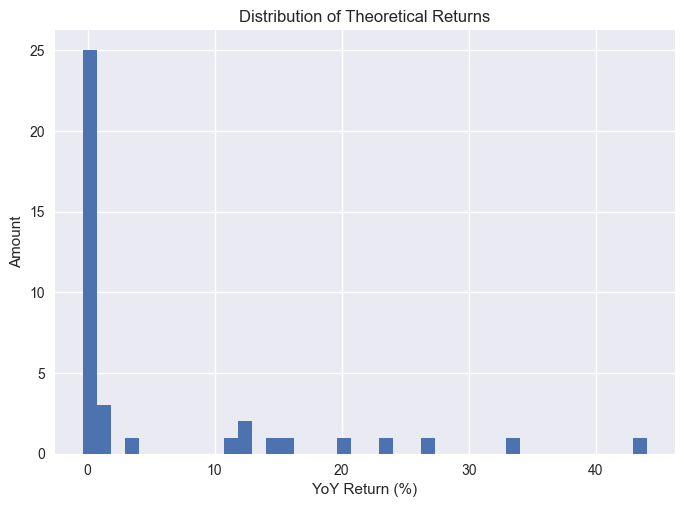

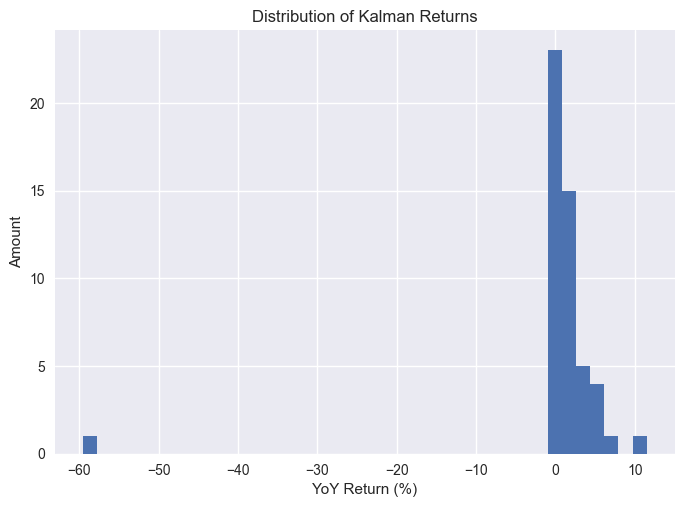

In [91]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-v0_8")

plt.hist(all_theoretical_returns_float, bins=40)
plt.title("Distribution of Theoretical Returns")
plt.xlabel("YoY Return (%)")
plt.ylabel("Amount")
plt.show()

plt.hist(all_kalman_returns_float, bins=40)
plt.title("Distribution of Kalman Returns")
plt.xlabel("YoY Return (%)")
plt.ylabel("Amount")
plt.show()

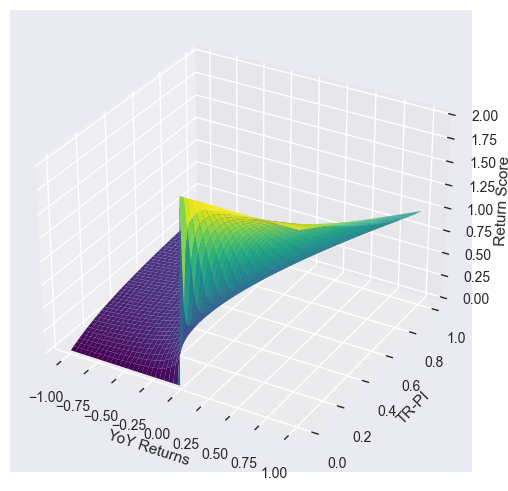

In [92]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x, y):
    return (x**2 + y**2) / 2  # Example: maps to [0, 1] for x,y in [-1, 1]
  
def return_score_mathematical(yoy_mean, gt_yoy):
    abs_diff = abs(yoy_mean - gt_yoy)
    score = (abs_diff + yoy_mean) / (abs_diff + gt_yoy)
    return score

# Create grid
yoy_mean_space = np.linspace(-0.99, 1, 100)
gt_yoy_space = np.linspace(0, 1, 100)
X, Y = np.meshgrid(yoy_mean_space, gt_yoy_space)
Z = return_score_mathematical(X, Y)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('YoY Returns')
ax.set_ylabel('TR-PI')
ax.set_zlabel('Return Score')
plt.show()

## Predictive Accuracy vs. Economic Peformance Comparison Between Models

In [ ]:
kalman_results_combined = [t for kalman_result in kalman_results for t in kalman_result]
transformer_results_combined = [t for transformer_result in transformer_results for t in transformer_result]
timemoe_results_combined = [t for timemoe_result in timemoe_results for t in timemoe_result]

# for model_results in zip(kalman_results, transformer_results, timemoe_results)

# test_mse_list = []

[('1. (SHV,SMH)', 0.000246, 3.62432, 6.24861, '4.96% +- 0.35%', 'TLOE*', nan),
 ('2. (SHV,ONEQ)',
  0.000404,
  14.37914,
  7.31014,
  '3.23% +- 0.22%',
  '33.16%',
  0.78),
 ('3. (SHV,PHO)',
  0.000413,
  12.98751,
  8.91065,
  '1.14% +- 0.06%',
  '14.67%',
  0.88),
 ('4. (SHV,PDP)',
  0.0009150000000000001,
  12.11053,
  7.17672,
  '3.39% +- 0.39%',
  '43.99%',
  0.72),
 ('5. (DVY,PEY)', 0.00141, 14.02045, 22.46558, '0.03% +- 0.02%', '0.10%', 1.0),
 ('6. (PFF,EMB)', 0.00145, 4.11138, 10.39903, '1.36% +- 0.24%', '0.71%', 1.01),
 ('7. (IGSB,BND)',
  0.0015600000000000002,
  0.47129,
  3.46026,
  '0.10% +- 0.16%',
  '-0.36%',
  1.0),
 ('8. (IFGL,SHV)',
  0.00395,
  0.84092,
  4.17398,
  '-59.52% +- 49.03%',
  '0.41%',
  0.4),
 ('9. (PRFZ,SCZ)',
  0.00447,
  62.79876,
  15.44644,
  '0.76% +- 0.24%',
  '0.31%',
  1.0),
 ('10. (IFGL,EMB)', 0.00461, 0.4754, 0.80221, '1.58% +- 0.25%', '0.53%', 1.01),
 ('1. (PFF,EMB)', 0.000771, 3.27634, 1.23317, '0.68% +- 0.07%', '0.35%', 1.0),
 ('2. (IFGL,E

In [ ]:
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')



# fig, axs = plt.subplots(1, len(model_keys) + 1, figsize=(7 * (len(model_keys) + 1), 6))
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()  # Flatten to 1D for easy indexing

# First plot: new method, artificial noise
from scipy.optimize import curve_fit
import numpy as np
def logarithmic(x, a, b, c):
    return a * np.log(x + b) + c

x0 = np.linspace(min(test_mse_list), max(test_mse_list), 100)
popt_log, _ = curve_fit(logarithmic, test_mse_list, profitability_list, p0=[-1e5, 2, 2e5], maxfev=5000)
y0 = logarithmic(x0, *popt_log)
axs[0].plot(x0, y0, color="purple", label="Logarithmic Fit")

axs[0].scatter(test_mse_list, profitability_list, label="Direct Empirical Measurements")
axs[0].set_title('Artificial Noise (same outlier criteria, none marked.)')
axs[0].set_xlabel('Test NMSE')
axs[0].set_ylabel('Profit (YoY Return %)')
axs[0].legend()

# Plots for each model (no TA)
for i, key in enumerate(model_keys, 1):
    # remove outliers where mse > 1 and profit > 0.2
    if key != 'Kalman_no_TA':
      outlier_idxs = [idx for idx, (mse_val, profit_val) in enumerate(zip(mse, profit)) if mse_val > 2 and profit_val > 0.2]
      mse_cleaned, profit_cleaned = [mse[i] for i in range(len(mse)) if i not in outlier_idxs], [profit[i] for i in range(len(profit)) if i not in outlier_idxs]
      mse_outliers, profit_outliers = [mse[i] for i in outlier_idxs], [profit[i] for i in outlier_idxs]
    else:
      mse_cleaned, profit_cleaned = mse, profit
      mse_outliers, profit_outliers = [], []


    x_i = np.linspace(min(mse_cleaned), max(mse_cleaned), 100)
    popt_log, _ = curve_fit(logarithmic, mse_cleaned, profit_cleaned, p0=[-1e5, 2, 2e5], maxfev=5000)
    y_i = logarithmic(x_i, *popt_log)
    axs[i].plot(x_i, y_i, color="purple", label="Logarithmic Fit")

    axs[i].scatter(mse, profit, label="Direct Empirical Measurements")
    axs[i].scatter(mse_outliers, profit_outliers, color="red", label="Marked as Outliers")
    axs[i].set_title(f'{key.replace("_no_TA", "")} (No TA)')
    axs[i].set_xlabel('Test NMSE')
    axs[i].set_ylabel('Profit (YoY Return %)')
    axs[i].legend()

fig.suptitle("Test MSE as an indicator of profitability for all models")
fig.tight_layout()
plt.show()

NameError: name 'logs' is not defined